In [1]:
%matplotlib inline
import librosa.display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import librosa
import IPython.display as ipd
import librosa.display
from scipy.io import wavfile
import sklearn as sk
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
from sklearn.metrics import roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
import soundfile as sf

# Загружаем аудио

In [2]:
files = [f for f in os.listdir('../../Test003/SF1/') if os.path.isfile(f) and f.endswith(".wav")]
print(files)

['002.wav', '003.wav', '004.wav']


In [3]:
c=[os.path.abspath(files[0])]
print(c)

['C:\\Users\\Alexandra\\Test003\\SF — копия (2) — копия\\002.wav']


# Делим дорожку на кадры

In [4]:
frame_length=15433
hop_length=500
frame = []
frame1=[]
for i in range(len(files)): 
    y , sr = librosa.load(files[i])
    frame1.append(librosa.util.frame(y, frame_length=frame_length, hop_length=hop_length))

In [5]:
frames=np.hstack((frame1))

In [6]:
len(frames[0])

2602

In [7]:
frames[0,3]

0.00019233007

In [8]:
#y , sr = librosa.load(files[0])
#frame1=librosa.util.frame(y, frame_length=frame_length, hop_length=hop_length)

In [9]:
#len(frame1[0])

In [10]:
#frame1[0,3]

In [11]:
#frame_length=15433
#hop_length=500
#frame = []
#for i in range(len(files)): 
#    y , sr = librosa.load(files[i])
#    frame=np.vstack(librosa.util.frame(y, frame_length=frame_length, hop_length=hop_length))

# Загружаем метки

Metki = [f for f in os.listdir('../../Test003/SF1/') if os.path.isfile(f) and f.endswith(".txt")]
metki = []
for i in range(len(Metki)): 
    m=np.hstack(np.genfromtxt(Metki[i]))
    metki.append(m)

In [12]:
Metki = [f for f in os.listdir('../../Test003/SF1/') if os.path.isfile(f) and f.endswith(".txt")]
metki = []
for i in range(len(Metki)): 
    metki.append(np.genfromtxt(Metki[i],dtype='str'))

In [13]:
metki=np.vstack(metki)

In [14]:
len(metki[0])

2

In [15]:
metki[11,1]

'5.876366'

In [16]:
#Metki = [f for f in os.listdir('../../Test003/SF1/') if os.path.isfile(f) and f.endswith(".txt")]
#metki1 = []
#metki2 = []
#for i in range(len(Metki)): 
#    m=np.genfromtxt(Metki[i],dtype='str')
#    metki1.append(m[i,0])
#   metki2.append(m[i,1])

In [17]:
#metki1=np.array(metki1)
#metki2=np.array(metki2)
#metki1 = metki1.reshape(-1,1)
#metki2 = metki2.reshape(-1,1)

In [18]:
#metki=np.hstack((metki1, metki2)).reshape(-1, 2)

In [19]:
#metki[0,1]

In [20]:
times_frame=frame_length/sr                      #Сколько в секунде кадров
times_hop=(hop_length/sr)                        #Сколько в секунде прыжков

Делим аудио по времени на кадры.

In [21]:
times = []
for i in range(len(frames[0])):
    times.append([times_hop*i,times_frame+times_hop*i])        
#print(times)

Загружаем в таблицу

In [22]:
%%time
df = pd.DataFrame(columns = ['mfccs','frames','event_label'])
m = times
for mark in m:
    df = df.append({'frames':(mark[0],mark[1])},ignore_index=True)
print(df)

     mfccs                                      frames event_label
0      NaN                   (0.0, 0.6999092970521542)         NaN
1      NaN  (0.022675736961451247, 0.7225850340136054)         NaN
2      NaN  (0.045351473922902494, 0.7452607709750567)         NaN
3      NaN   (0.06802721088435373, 0.7679365079365079)         NaN
4      NaN   (0.09070294784580499, 0.7906122448979592)         NaN
...    ...                                         ...         ...
2597   NaN     (58.888888888888886, 59.58879818594104)         NaN
2598   NaN      (58.91156462585034, 59.61147392290249)         NaN
2599   NaN     (58.93424036281179, 59.634149659863944)         NaN
2600   NaN      (58.956916099773245, 59.6568253968254)         NaN
2601   NaN      (58.97959183673469, 59.67950113378684)         NaN

[2602 rows x 3 columns]
Wall time: 18.3 s


# Смотрим попала ли метка в кадр

In [23]:
block = np.zeros((len(frames[0])), dtype=int)
for i,mark in enumerate(times):   
    for j in range(len(metki)):    
        if (mark[0]) <= float(metki[j,0]) <= (mark[1]) and (mark[0]) <= float(metki[j,1]) <= (mark[1]):
            block[i]=1
#print(block)

In [24]:
df['event_label'] = block
df.head()

,mfccs,frames,event_label
0,NaN,"(0.0, 0.6999092970521542)",0
1,NaN,"(0.022675736961451247, 0.7225850340136054)",0
2,NaN,"(0.045351473922902494, 0.7452607709750567)",0
3,NaN,"(0.06802721088435373, 0.7679365079365079)",0
4,NaN,"(0.09070294784580499, 0.7906122448979592)",0


In [25]:
df["event_label"].value_counts()

0    2207
1     395
Name: event_label, dtype: int64

# mel filterbank

In [638]:
mel = []
for i in range(len(frames[0])):   
    mel.append(librosa.feature.melspectrogram(y=frames[:,i], n_fft = 512, hop_length = 500, win_length = None, window = 'hann', center = True, dtype = None, pad_mode = 'reflect'))

In [639]:
MEL = []
scaler = preprocessing.StandardScaler()
for i in range(len(mel)): 
    scaler.fit(mel[i])
for i in range(len(mel)): 
    MEL.append(scaler.transform(mel[i]))

In [640]:
MEL=np.array(MEL)
MEL.shape

(2602, 128, 31)

In [641]:
MEL2 = []
for i in range(len(frames[0])): 
    MEL2.append(MEL[i].flatten())

In [642]:
MEL2=np.array(MEL2, dtype=float)
#print(MEL2[0])
MEL2.shape

(2602, 3968)

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

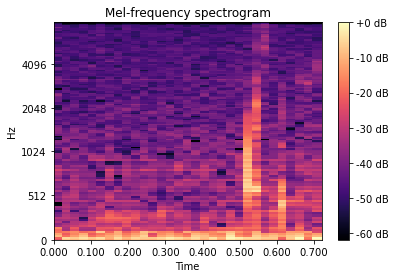

In [649]:
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(mel[0], ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

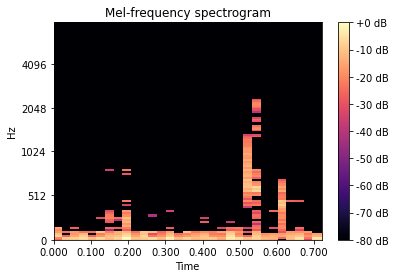

In [650]:
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(MEL[0], ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

# Кепстральные коэффициенты Mel-частоты (MFCC)

Делим коэффициенты на кадры

In [248]:
mfccs1 = []
for i in range(len(frames[0])):   
    mfccs1.append(librosa.feature.mfcc(y=frames[:,i], sr=sr, hop_length=512, htk=True, n_mfcc=15,dct_type = 2,norm = None))

In [249]:
mfccs1=np.array(mfccs1)

Нормируем все коэффициенты

In [421]:
mfccs = []
scaler = preprocessing.StandardScaler()
for i in range(len(mfccs1)): 
    scaler.fit(mfccs1[i])
for i in range(len(mfccs1)): 
    mfccs.append(scaler.transform(mfccs1[i]))

In [420]:
#mfccs = []
#for i in range(len(frames[0])):   
#    mfccs.append(sk.preprocessing.scale(mfccs1[i], axis=1, with_mean= True, with_std= True, copy=True))

In [423]:
MFCCS = []
for i in range(len(frames[0])): 
    MFCCS.append(mfccs[i].flatten())
#    print(MFCCS[0])

In [597]:
MFCCS=np.array(MFCCS, dtype=float)
MFCCS.shape

(2602, 465)

In [425]:
df['mfccs'] = list(MFCCS)
#df.head()

# Оконное преобразование Фурье (STFT).

In [426]:
stft1 = []
for i in range(len(frames[0])):   
    stft1.append(librosa.stft(y=frames[:,i], n_fft = 512, hop_length = 500, win_length = None, window = 'hann', center = True, dtype = None, pad_mode = 'reflect'))

In [427]:
window=('kaiser', 4.0)

In [428]:
stft1 = []
for i in range(len(frames[0])):   
    stft1.append(librosa.stft(y=frames[:,i], n_fft = 512, hop_length = 500, win_length = None, window = window, center = True, dtype = None, pad_mode = 'reflect'))

boxcar
triang
blackman
hamming
hann
bartlett
flattop
parzen
bohman
blackmanharris
nuttall
barthann
cosine
exponential
tukey
taylor
kaiser (нужна бета)
gaussian (требуется стандартное отклонение)
general_cosine (требуются весовые коэффициенты)
general_gaussian (требуется мощность, ширина)
general_hamming (требуется оконный коэффициент)
dpss (требуется нормализованная половина полосы пропускания)
chebwin (требуется затухание)
(В некоторых источниках используется альфа = бета / пи.

In [429]:
stft2 = []
for i in range(len(frames[0])): 
    stft2.append(stft1[i].astype(np.float32))

<ipython-input-429-9b7e0eff9cae>:3: ComplexWarning: Casting complex values to real discards the imaginary part
  stft2.append(stft1[i].astype(np.float32))


In [431]:
stft = []
scaler = preprocessing.StandardScaler()
for i in range(len(stft2)): 
    scaler.fit(stft2[i])
for i in range(len(stft2)): 
    stft.append(scaler.transform(stft2[i]))

In [432]:
#stft = []
#for i in range(len(frames[0])):   
#    stft.append(sk.preprocessing.scale(stft2[i], axis=1, with_mean= True, with_std= True, copy=True))

D:\Alexandra\Anaconda\lib\site-packages\librosa\core\spectrum.py:1641: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn(


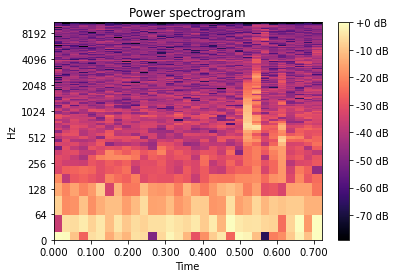

In [433]:
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(stft1[0],
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

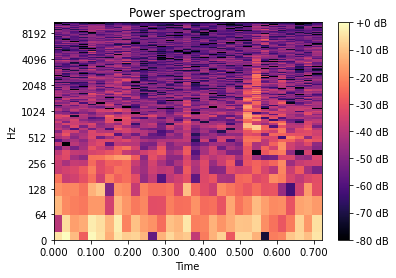

In [434]:
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(stft[0],
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

In [435]:
STFT = []
for i in range(len(frames[0])): 
    STFT.append(stft[i].flatten())

In [436]:
STFT=np.array(STFT, dtype=float)
#print(STFT[0])
STFT.shape

(2602, 7967)

In [437]:
#x_df = STFT
#y_df = block

# Вейвлет-преобразование 

In [438]:
import pywt

In [439]:
#Возвращает список доступных встроенных семейств вейвлетов.
#Хаар ( haar )
#Добеши ( db )
#Symlets ( sym )
#Койфлеты ( coif )
#Биортогональный ( bior )
#Обратный биортогональный ( rbio )
#«Дискретное» FIR-приближение вейвлета Мейера ( dmey )
pywt.families()

['haar',
 'db',
 'sym',
 'coif',
 'bior',
 'rbio',
 'dmey',
 'gaus',
 'mexh',
 'morl',
 'cgau',
 'shan',
 'fbsp',
 'cmor']

In [440]:
print(pywt.wavelist( 'dmey'))

['dmey']


In [441]:
wavelet = pywt.Wavelet('dmey')
print(wavelet)

Wavelet dmey
  Family name:    Discrete Meyer (FIR Approximation)
  Short name:     dmey
  Filters length: 62
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       symmetric
  DWT:            True
  CWT:            False


In [555]:
waveletcad = []
for i in range(len(frames[0])):  
    cad  = pywt.dwt(frames[:,i], wavelet , mode='symmetric', axis=-1)
    waveletcad.append(cad)

In [443]:
#wavelet.filter_bank
#(w.dec_lo, w.dec_hi, w.rec_lo, w.rec_hi) 

In [556]:
waveletcAD = []
scaler = preprocessing.StandardScaler()
for i in range(len(waveletcad)): 
    scaler.fit(waveletcad[i])
for i in range(len(waveletcad)): 
    waveletcAD.append(scaler.transform(waveletcad[i]))

In [557]:
waveletcAD=np.array(waveletcAD, dtype=float)
#print(waveletCA[0])
waveletcAD.shape

(2602, 2, 7747)

In [59]:
#x_df = waveletcAD
#y_df = block

# Делим на обучающую и тестовую выборки и обучаем

In [612]:
x_df = MEL2

In [613]:
y_df = block

In [579]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz
from sklearn import tree
from IPython.display import Image
from sklearn.tree import DecisionTreeClassifier, export_graphviz

Видим, что выборка несбалонсированна. 

In [614]:
x_train, x_valid, y_train, y_valid = train_test_split(x_df,y_df, test_size=0.3, random_state=17)

In [615]:
np.count_nonzero(y_valid == 1)

121

In [616]:
np.count_nonzero(y_valid == 0)

660

In [617]:
 np.count_nonzero(y_train == 1)

274

In [618]:
np.count_nonzero(y_train == 0)

1547

# Нейронная сеть

In [587]:
import tensorflow as tf
from tensorflow import keras
from  tensorflow.keras import layers

In [622]:
r=len(x_train)
u=len(x_train[0])
print(u,r)

3968 1821


In [623]:
model = tf.keras.Sequential([                                       #Sequential группирует линейную стопку слоев в tf.keras.Model.
    tf.keras.layers.Flatten(input_shape=(u,)),                      #преобразует матрицу ввода в единый массив.
#   tf.keras.layers.Dense(128, kernel_initializer='orthogonal'),    #генерирует случайные веса
    tf.keras.layers.Dense(128, activation=tf.nn.relu),              #Применяет функцию активации выпрямленного линейного блока.   
#Схемы регуляризации добавляемые к весам слоя (ядро и сдвиг), такие как L1 или L2 регуляризации.
#kernel_regularizer : функция регуляризатора, применяемая к матрице весов ядра.
#bias_regularizer : функция регуляризатора, применяемая к вектору смещения.
    tf.keras.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.Dense(64, bias_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax),   #2 категории 0 и 1; преобразует вектор значений в распределение вероятностей
])

In [624]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [625]:
history = model.fit(x_train, y_train, epochs=5)

Epoch 1/5
57/57 [==============================] - 2s 14ms/step - loss: 15.1834 - accuracy: 0.8029
Epoch 2/5
57/57 [==============================] - 1s 18ms/step - loss: 12.4661 - accuracy: 0.8880
Epoch 3/5
57/57 [==============================] - 1s 19ms/step - loss: 11.6298 - accuracy: 0.9050
Epoch 4/5
57/57 [==============================] - 1s 19ms/step - loss: 10.9420 - accuracy: 0.8990: 0s - loss: 10.7942 - accuracy: 
Epoch 5/5
57/57 [==============================] - 1s 15ms/step - loss: 9.8819 - accuracy: 0.9116


In [536]:
test_loss, test_acc = model.evaluate(x_valid, y_valid)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

25/25 [==============================] - 0s 2ms/step - loss: 0.4472 - accuracy: 0.8451
Test accuracy: 0.8450704216957092
Test loss: 0.44717085361480713


In [537]:
predictions = model.predict(x_valid)

In [538]:
from sklearn.metrics import classification_report
print(classification_report(y_valid,predictions.argmax(axis=1)))
print(classification_report(y_valid,np.zeros(y_valid.shape[0])))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       660
           1       0.00      0.00      0.00       121

    accuracy                           0.85       781
   macro avg       0.42      0.50      0.46       781
weighted avg       0.71      0.85      0.77       781

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       660
           1       0.00      0.00      0.00       121

    accuracy                           0.85       781
   macro avg       0.42      0.50      0.46       781
weighted avg       0.71      0.85      0.77       781



D:\Alexandra\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [540]:
predictions.argmax(axis=1), y_valid

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

# Сверточная нейронная сеть

In [541]:
x_cnn_df = mfccs
y_cnn_df = block

In [542]:
x_cnn_train, x_cnn_valid, y_cnn_train, y_cnn_valid = train_test_split(x_cnn_df,y_cnn_df, test_size=0.3, random_state=17)

In [543]:
x_cnn_train=np.array(x_cnn_train)
x_cnn_valid=np.array(x_cnn_valid)

In [544]:
model = tf.keras.Sequential([    
    tf.keras.layers.Conv1D(64, kernel_size = 3, activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(64, kernel_size = 3, activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(input_shape=()),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)   
])

In [545]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [546]:
model.fit(x_cnn_train, y_cnn_train, epochs=5)

Epoch 1/5
57/57 [==============================] - 2s 8ms/step - loss: 0.4600 - accuracy: 0.8287
Epoch 2/5
57/57 [==============================] - 0s 8ms/step - loss: 0.3926 - accuracy: 0.8495
Epoch 3/5
57/57 [==============================] - 0s 7ms/step - loss: 0.3566 - accuracy: 0.8501
Epoch 4/5
57/57 [==============================] - 0s 6ms/step - loss: 0.3063 - accuracy: 0.8666
Epoch 5/5
57/57 [==============================] - 0s 8ms/step - loss: 0.2777 - accuracy: 0.8918: 0s - loss: 0.2694 - accu


In [547]:
test_loss, test_acc = model.evaluate(x_cnn_valid, y_cnn_valid)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

25/25 [==============================] - 1s 3ms/step - loss: 0.2847 - accuracy: 0.8848
Test accuracy: 0.8847631216049194
Test loss: 0.2846831977367401


Вейвлет

In [558]:
x_cnn_df = waveletcAD
y_df=block

In [559]:
x_cnn_train, x_cnn_valid, y_cnn_train, y_cnn_valid = train_test_split(x_cnn_df,y_df, test_size=0.3, random_state=17)

In [560]:
model2 = tf.keras.Sequential([    
    tf.keras.layers.Conv1D(128, kernel_size = 1, activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=1,padding='same'),
    tf.keras.layers.Conv1D(128, kernel_size = 1, activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=1,padding='same'),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax),   
    tf.keras.layers.Flatten(input_shape=())
    ])

In [561]:
model2.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [562]:
model2.fit(x_cnn_train, y_cnn_train, epochs=5)

Epoch 1/5
57/57 [==============================] - 5s 35ms/step - loss: 5.2875 - accuracy: 0.7062
Epoch 2/5
57/57 [==============================] - 1s 26ms/step - loss: 3.1215 - accuracy: 0.8490
Epoch 3/5
57/57 [==============================] - 2s 26ms/step - loss: 3.1184 - accuracy: 0.8495
Epoch 4/5
57/57 [==============================] - 1s 26ms/step - loss: 3.1184 - accuracy: 0.8495
Epoch 5/5
57/57 [==============================] - 1s 26ms/step - loss: 3.1184 - accuracy: 0.8495


In [563]:
test_loss, test_acc = model2.evaluate(x_cnn_valid, y_cnn_valid)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

25/25 [==============================] - 0s 6ms/step - loss: 3.1903 - accuracy: 0.8438
Test accuracy: 0.8437899947166443
Test loss: 3.1903178691864014


# Дерево решений

Обучаем модель

In [564]:
tree = DecisionTreeClassifier(max_depth=5, random_state=17)
tree.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=17)

Оценка модели

In [565]:
tree_pred = tree.predict(x_valid)
accuracy_score(y_valid, tree_pred) 

0.8873239436619719

ROC-кривая (англ. receiver operating characteristic, рабочая характеристика приёмника) — график, позволяющий оценить
качество бинарной классификации, отображает соотношение между долей объектов от общего количества носителей признака,
верно классифицированных как несущие признак (англ. true positive rate, TPR, называемой чувствительностью алгоритма
классификации), и долей объектов от общего количества объектов, не несущих признака, ошибочно классифицированных
как несущие признак (англ. false positive rate, FPR, величина 1-FPR называется специфичностью алгоритма классификации) 
при варьировании порога решающего правила.

Также известна как кривая ошибок. Анализ классификаций с применением ROC-кривых называется ROC-анализом.

Количественная интерпретация ROC даёт показатель AUC (англ. Area Under Curve, площадь под кривой) — площадь, ограниченная
ROC-кривой и осью доли ложных положительных классификаций. Чем выше показатель AUC, тем качественнее классификатор, 
при этом значение 0,5 демонстрирует непригодность выбранного метода классификации (соответствует случайному гаданию).
Значение менее 0,5 говорит, что классификатор действует с точностью до наоборот: если положительные назвать отрицательными
и наоборот, классификатор будет работать лучше.

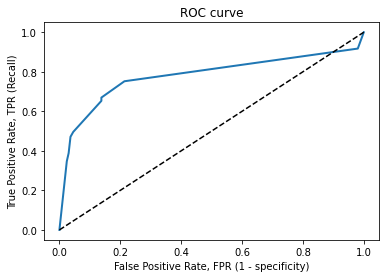

In [566]:
fpr, tpr, thresholds = roc_curve(y_valid, tree.predict_proba(x_valid)[:,1], pos_label=1)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel('False Positive Rate, FPR (1 - specificity)')
    plt.ylabel('True Positive Rate, TPR (Recall)')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
plot_roc_curve(fpr, tpr)
plt.show()

Precision можно интерпретировать как долю объектов, названных классификатором положительными и при этом действительно 
являющимися положительными, а recall показывает, какую долю объектов положительного класса из всех объектов положительного
класса нашел алгоритм. Precision и recall не зависят, в отличие от accuracy, от соотношения классов и потому применимы 
в условиях несбалансированных выборок.

F-мера достигает максимума при максимальной полноте и точности, и близка к нулю, если один из аргументов близок к нулю. 
F-мера является хорошим кандидатом на формальную метрику оценки качества классификатора. 
Она сводит к одному числу две других основополагающих метрики: точность и полноту. 
Имея "F-меру" гораздо проще ответить на вопрос: "поменялся алгоритм в лучшую сторону или нет?"

In [567]:
report = classification_report(y_valid, tree.predict(x_valid), target_names=['0', '1'])
print(report)

              precision    recall  f1-score   support

           0       0.91      0.96      0.94       660
           1       0.70      0.47      0.56       121

    accuracy                           0.89       781
   macro avg       0.81      0.72      0.75       781
weighted avg       0.88      0.89      0.88       781



# Настроим параметры модели

In [99]:
tree_params = {'max_depth': range(1,11),'max_features': range(1,19)}

In [100]:
tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)

In [101]:
tree_grid.fit(x_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 864 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:    8.8s finished


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=5, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 11),
                         'max_features': range(1, 19)},
             verbose=True)

In [102]:
tree_grid.best_score_,tree_grid.best_params_

(0.8500842992623815, {'max_depth': 2, 'max_features': 11})

In [103]:
accuracy_score(y_valid, tree_grid.predict(x_valid))

0.8220230473751601

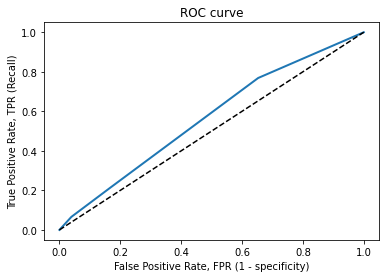

In [104]:
fpr, tpr, thresholds = roc_curve(y_valid, tree_grid.predict_proba(x_valid)[:,1], pos_label=1)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel('False Positive Rate, FPR (1 - specificity)')
    plt.ylabel('True Positive Rate, TPR (Recall)')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
plot_roc_curve(fpr, tpr)
plt.show()

In [105]:
report = classification_report(y_valid, tree_grid.predict(x_valid), target_names=['0', '1'])
print(report)

              precision    recall  f1-score   support

           0       0.85      0.96      0.90       660
           1       0.24      0.07      0.10       121

    accuracy                           0.82       781
   macro avg       0.54      0.51      0.50       781
weighted avg       0.75      0.82      0.78       781



# Метод ближайших соседей

Обучаем модель

In [106]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=10)

Оценка модели

In [107]:
knn_pred = knn.predict(x_valid)
accuracy_score(y_valid, knn_pred) 

0.8950064020486556

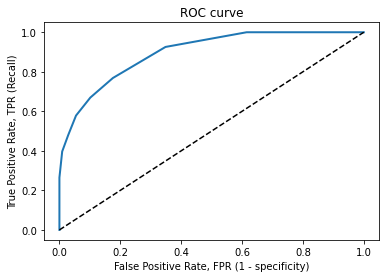

In [108]:
fpr, tpr, thresholds = roc_curve(y_valid, knn.predict_proba(x_valid)[:,1], pos_label=1)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel('False Positive Rate, FPR (1 - specificity)')
    plt.ylabel('True Positive Rate, TPR (Recall)')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
plot_roc_curve(fpr, tpr)
plt.show()

In [109]:
report = classification_report(y_valid, knn.predict(x_valid), target_names=['0', '1'])
print(report)

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       660
           1       0.75      0.48      0.59       121

    accuracy                           0.90       781
   macro avg       0.83      0.73      0.76       781
weighted avg       0.89      0.90      0.89       781



Настроим параметры модели

In [110]:
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1))])

In [111]:
knn_params = {'knn__n_neighbors': range(1, 10)}

In [112]:
knn_grid = GridSearchCV(knn_pipe, knn_params, cv=5, n_jobs=-1, verbose=True)

In [113]:
knn_grid.fit(x_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    8.4s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn',
                                        KNeighborsClassifier(n_jobs=-1))]),
             n_jobs=-1, param_grid={'knn__n_neighbors': range(1, 10)},
             verbose=True)

In [114]:
knn_grid.best_params_, knn_grid.best_score_

({'knn__n_neighbors': 1}, 0.9357458979376789)

In [115]:
accuracy_score(y_valid, knn_grid.predict(x_valid))

0.9603072983354674

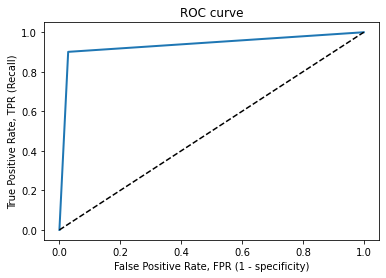

In [116]:
fpr, tpr, thresholds = roc_curve(y_valid, knn_grid.predict_proba(x_valid)[:,1], pos_label=1)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel('False Positive Rate, FPR (1 - specificity)')
    plt.ylabel('True Positive Rate, TPR (Recall)')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
plot_roc_curve(fpr, tpr)
plt.show()

In [117]:
report = classification_report(y_valid, knn_grid.predict(x_valid), target_names=['0', '1'])
print(report)

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       660
           1       0.85      0.90      0.88       121

    accuracy                           0.96       781
   macro avg       0.92      0.94      0.93       781
weighted avg       0.96      0.96      0.96       781



# Случайный лес

In [118]:
forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=17)
print(np.mean(cross_val_score(forest, x_train, y_train, cv=5))) 

0.8632605750413969


In [119]:
forest_params = {'max_depth': range(1,11), 'max_features': range(1,19)}

In [120]:
forest_grid = GridSearchCV(forest, forest_params, cv=5, n_jobs=-1, verbose=True)

In [121]:
forest_grid.fit(x_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  3.6min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 11),
                         'max_features': range(1, 19)},
             verbose=True)

In [122]:
forest_grid.best_params_, forest_grid.best_score_ 

({'max_depth': 10, 'max_features': 12}, 0.8577690802348338)

In [123]:
accuracy_score(y_valid, forest_grid.predict(x_valid))

0.8501920614596671

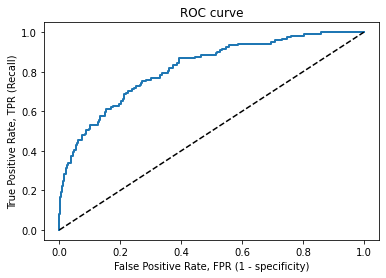

In [124]:
fpr, tpr, thresholds = roc_curve(y_valid, forest_grid.predict_proba(x_valid)[:,1], pos_label=1)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel('False Positive Rate, FPR (1 - specificity)')
    plt.ylabel('True Positive Rate, TPR (Recall)')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
plot_roc_curve(fpr, tpr)
plt.show()

In [125]:
report = classification_report(y_valid, forest_grid.predict(x_valid), target_names=['0', '1'])
print(report)

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       660
           1       1.00      0.03      0.06       121

    accuracy                           0.85       781
   macro avg       0.92      0.52      0.49       781
weighted avg       0.87      0.85      0.79       781



# Логистическая регрессия 

In [126]:
model = LogisticRegression(solver='liblinear', random_state=0)

In [127]:
model.fit(x_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [128]:
#LogisticRegression(
#    C=1.0, 
#    class_weight=None, 
#    dual=False, 
#    fit_intercept=True,
#    intercept_scaling=1, 
#    l1_ratio=None, 
#    max_iter=100,
#    multi_class='warn', 
#    n_jobs=None, 
#    penalty='l2',
#    random_state=0, 
#    solver='liblinear', 
#    tol=0.0001, 
#    verbose=0,
#    warm_start=False
#)

In [129]:
model = LogisticRegression(solver='liblinear', random_state=0).fit(x_train, y_train)

In [130]:
#Это пример двоичной классификации, и y может быть 0 или 1
model.classes_

array([0, 1])

In [131]:
#Можно получить значение наклона b1 и точку пересечения b0 линейной функции f следующим образом
#b0 задается внутри одномерного массива, а b1 — внутри двумерного массива
model.intercept_
model.coef_

array([[ 1.01128228e+00, -1.30327918e+00,  7.53231856e-01,
        -2.01742725e-01,  4.63130175e-01, -3.66791725e-01,
        -2.78358933e-01,  3.95640827e-02,  1.33555903e-01,
        -1.39424809e-01,  4.38649029e-02,  2.35156891e-01,
        -3.53777928e-02,  7.90398822e-02,  3.16612407e-01,
        -2.33345506e-01,  2.63112408e-01, -7.67046324e-02,
         2.28348614e-01, -2.75146363e-01, -2.04666472e-02,
        -4.00894508e-02,  2.32561687e-01, -3.26981311e-01,
         3.05152986e-01, -6.89445333e-01,  9.55727753e-02,
        -2.41097380e-01,  4.30528931e-01, -1.15161865e+00,
         7.49153882e-01,  4.80199544e-01, -7.94599000e-01,
         4.84626832e-02, -1.75244138e-01, -1.90976659e-01,
        -5.90677145e-02,  4.20440203e-01, -6.35092322e-02,
         7.32190397e-02, -9.32715397e-02,  4.64303984e-02,
        -8.96735474e-02,  6.51613783e-02, -1.89059239e-01,
        -2.29524129e-01,  3.19122369e-01, -1.51823536e-01,
         3.57782140e-01,  6.00392126e-02,  1.30341250e-0

In [132]:
#Первый столбец — это вероятность того, что прогнозируемый результат будет равен нулю, то есть 1−p(x).
#Второй столбец — это вероятность того, что на выходе будет единица или p(x).
model.predict_proba(x_valid)

array([[0.98735049, 0.01264951],
       [0.89243544, 0.10756456],
       [0.93216558, 0.06783442],
       ...,
       [0.57490081, 0.42509919],
       [0.96876729, 0.03123271],
       [0.04516939, 0.95483061]])

In [133]:
#Фактические прогнозы
model.predict(x_valid)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [134]:
model.score(x_valid, y_valid)

0.7503201024327785

In [135]:
#Чтобы создать матрицу ошибок, вы можете использовать confusion_matrix() и предоставить
#фактические и прогнозируемые результаты в качестве аргументов:
confusion_matrix(y_valid, model.predict(x_valid))

array([[573,  87],
       [108,  13]], dtype=int64)

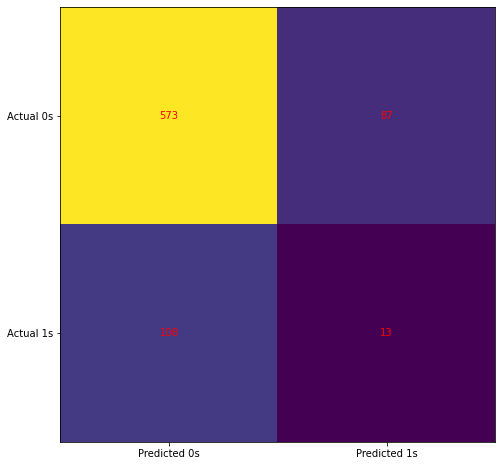

In [136]:
cm = confusion_matrix(y_valid, model.predict(x_valid))
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

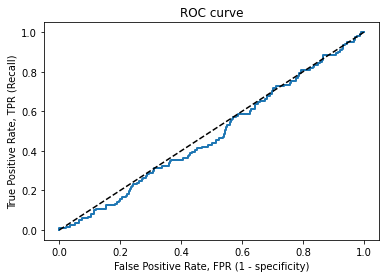

In [137]:
fpr, tpr, thresholds = roc_curve(y_valid, model.predict_proba(x_valid)[:,1], pos_label=1)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel('False Positive Rate, FPR (1 - specificity)')
    plt.ylabel('True Positive Rate, TPR (Recall)')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
plot_roc_curve(fpr, tpr)
plt.show()

In [138]:
report = classification_report(y_valid, model.predict(x_valid), target_names=['0', '1'])
print(report)

              precision    recall  f1-score   support

           0       0.84      0.87      0.85       660
           1       0.13      0.11      0.12       121

    accuracy                           0.75       781
   macro avg       0.49      0.49      0.49       781
weighted avg       0.73      0.75      0.74       781



In [139]:
print(classification_report(y_valid, model.predict(x_valid)))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85       660
           1       0.13      0.11      0.12       121

    accuracy                           0.75       781
   macro avg       0.49      0.49      0.49       781
weighted avg       0.73      0.75      0.74       781



# Улучшенная модель логистической регрессии Попытка провалилась (C=10.0)

In [140]:
model = LogisticRegression(solver='liblinear', C=10.0, random_state=0)
model.fit(x_train, y_train)

LogisticRegression(C=10.0, random_state=0, solver='liblinear')

In [141]:
model.intercept_,model.coef_

(array([-1.77653233]),
 array([[ 1.30962078e+00, -1.77092813e+00,  1.09501816e+00,
         -4.05271499e-01,  7.42126635e-01, -5.79739885e-01,
         -2.77281743e-01,  9.48868525e-03,  2.92825983e-01,
         -3.41556620e-01,  1.24158687e-01,  2.83417859e-01,
         -1.45489239e-02, -2.55483415e-02,  6.29631983e-01,
         -5.72956479e-01,  5.57536098e-01, -3.23742343e-01,
          4.66640668e-01, -4.49905358e-01,  1.01006504e-01,
         -2.21812689e-01,  5.46753901e-01, -7.20529389e-01,
          7.39219617e-01, -1.26194283e+00,  4.95990676e-01,
         -6.60068673e-01,  8.83604425e-01, -1.71031284e+00,
          1.05909971e+00,  5.50391269e-01, -9.03125659e-01,
          6.51699426e-03, -1.31561144e-01, -3.31306457e-01,
         -5.09481772e-02,  5.61073414e-01, -9.25932112e-02,
          6.11276501e-02, -1.03611828e-01,  6.66539641e-02,
         -1.25677976e-01,  7.22148913e-02, -1.94388132e-01,
         -3.95497146e-01,  5.65072520e-01, -3.92269187e-01,
          6.30778

In [142]:
model.predict_proba(x_valid)

array([[0.99382918, 0.00617082],
       [0.94641337, 0.05358663],
       [0.9668801 , 0.0331199 ],
       ...,
       [0.58281649, 0.41718351],
       [0.95592122, 0.04407878],
       [0.01628086, 0.98371914]])

In [143]:
model.predict(x_valid)

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [144]:
model.score(x_valid, y_valid)

0.736235595390525

In [145]:
confusion_matrix(y_valid, model.predict(x_valid))

array([[561,  99],
       [107,  14]], dtype=int64)

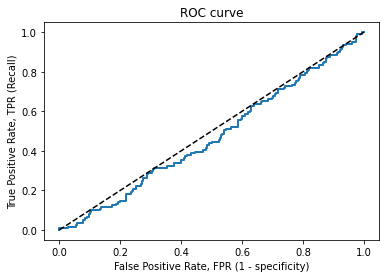

In [146]:
fpr, tpr, thresholds = roc_curve(y_valid, model.predict_proba(x_valid)[:,1], pos_label=1)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel('False Positive Rate, FPR (1 - specificity)')
    plt.ylabel('True Positive Rate, TPR (Recall)')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
plot_roc_curve(fpr, tpr)
plt.show()

In [147]:
print(classification_report(y_valid, model.predict(x_valid)))

              precision    recall  f1-score   support

           0       0.84      0.85      0.84       660
           1       0.12      0.12      0.12       121

    accuracy                           0.74       781
   macro avg       0.48      0.48      0.48       781
weighted avg       0.73      0.74      0.73       781



# Стохастический градиентный спуск (Stochastic Gradient Descent SGD)

In [148]:
sgd_clf = SGDClassifier(random_state=42) 
sgd_clf.fit(x_valid, y_valid) 
y_train_pred = cross_val_predict(sgd_clf, x_valid, y_valid, cv=3)

In [149]:
accuracy_score(y_valid, y_train_pred)

0.7695262483994878

In [150]:
np.mean(cross_val_score(sgd_clf, x_train, y_train, cv=3))

0.71554091158704

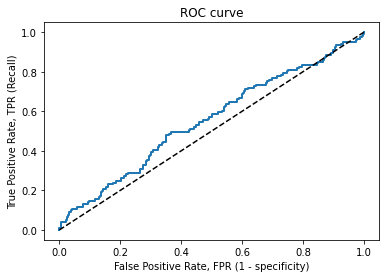

In [151]:
y_scores = cross_val_predict(sgd_clf, x_valid, y_valid, cv=3, method="decision_function")
fpr, tpr, thresholds = roc_curve(y_valid, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel('False Positive Rate, FPR (1 - specificity)')
    plt.ylabel('True Positive Rate, TPR (Recall)')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
plot_roc_curve(fpr, tpr)
plt.show()

In [152]:
print(classification_report(y_valid, sgd_clf.predict(x_valid)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       660
           1       0.97      0.92      0.94       121

    accuracy                           0.98       781
   macro avg       0.98      0.96      0.97       781
weighted avg       0.98      0.98      0.98       781



# Визуализация дерева решений

In [153]:
dot_data = tree.export_graphviz(tree_grid.best_estimator_, out_file='tree.dot',filled=True)

AttributeError: 'DecisionTreeClassifier' object has no attribute 'export_graphviz'

In [154]:
!dir *png

 Том в устройстве C имеет метку Acer
 Серийный номер тома: 3C4E-9E6E

 Содержимое папки C:\Users\Alexandra\Test003\SF — копия (2) — копия

04.12.2021  16:43            14 305 ROC.png
02.11.2021  15:37           160 351 tree.png
27.10.2021  18:28            70 822 tree1.png
               3 файлов        245 478 байт
               0 папок  18 226 438 144 байт свободно


In [155]:
!dot -Tpng tree.dot -o tree.png

"dot" не является внутренней или внешней
командой, исполняемой программой или пакетным файлом.


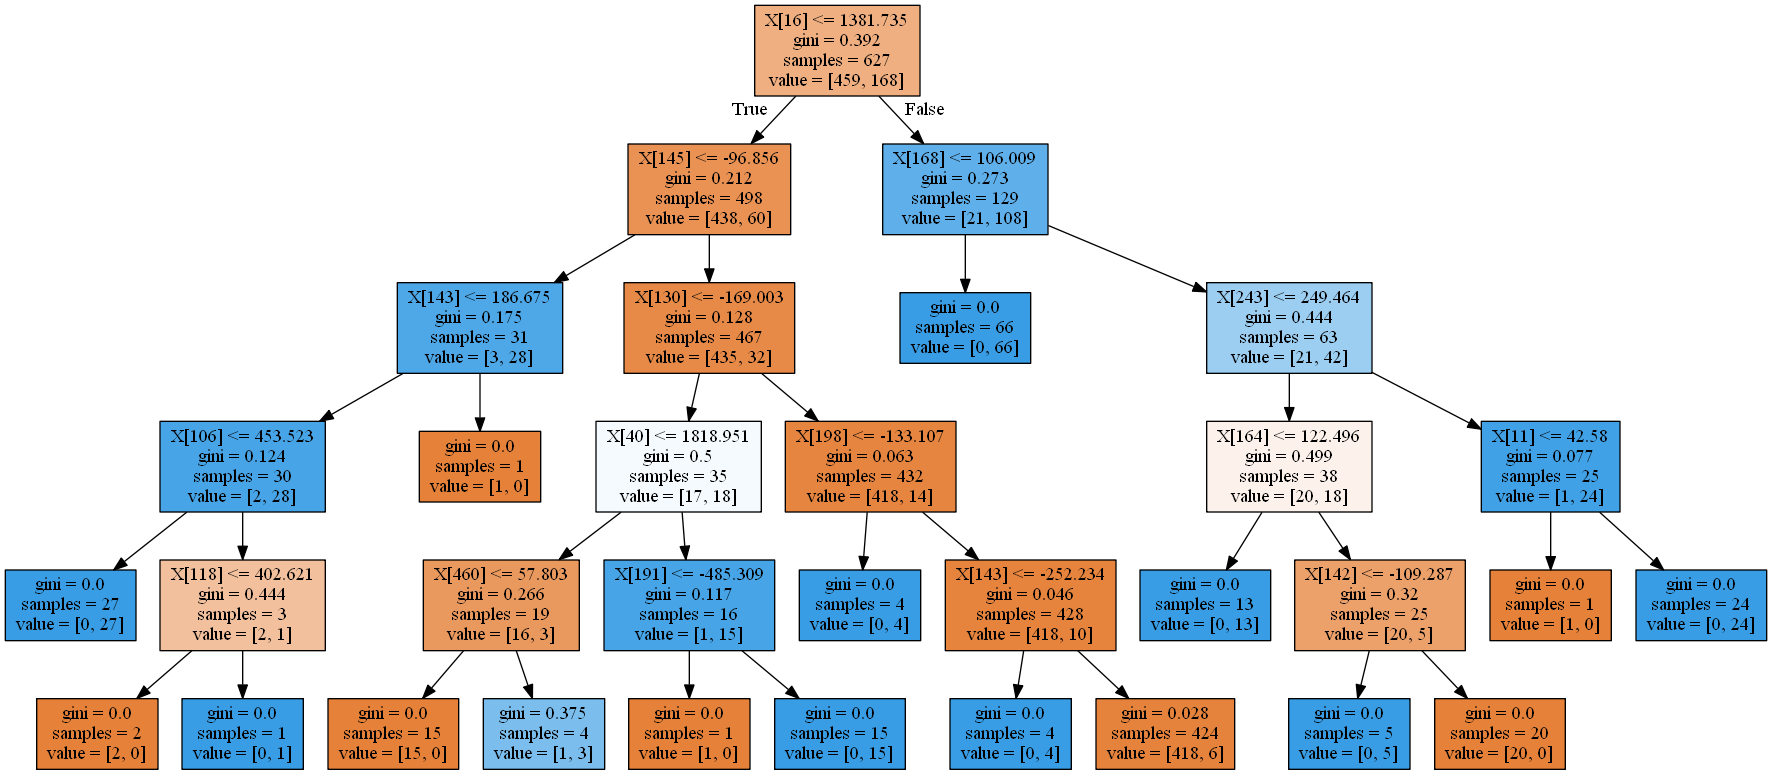

In [156]:
Image(filename='tree.png') 

# Построение кривых валидации для kNN

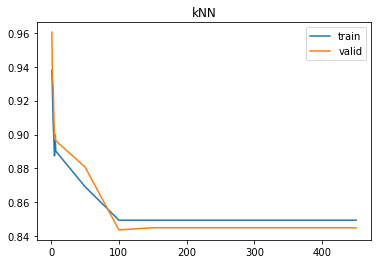

In [157]:
train_scores, valid_scores = [], []
n_neighb = [1, 2, 3, 5, 6, 7] + list(range(50, 500, 50))

for k in n_neighb:
    knn = KNeighborsClassifier(n_neighbors=k)
    train_scores.append(np.mean(cross_val_score(knn, x_train, y_train, cv=5)))
    knn.fit(x_train, y_train)
    valid_scores.append(accuracy_score(y_valid, knn.predict(x_valid)))  

plt.plot(n_neighb, train_scores, label='train')
plt.plot(n_neighb, valid_scores, label='valid')
plt.title('kNN')
plt.legend();

In [158]:
mel_basis = librosa.filters.mel(sr=22050, n_fft=512, n_mels=10,fmin=0, fmax=sr / 2)

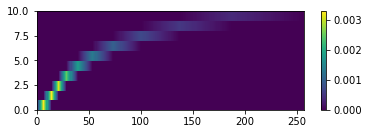

In [159]:
plt.subplot(2,1,1)
plt.pcolormesh(mel_basis)
plt.colorbar()

In [160]:
sr = 22050
mel_basis = librosa.filters.mel(sr=sr, n_fft=512, n_mels=10,fmin=0, fmax=sr / 2, htk=False, norm=None)

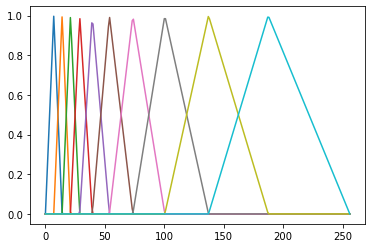

In [161]:
plt.plot(mel_basis.T)
plt.show()